In [1]:
!pip list

Package                                 Version     Editable project location
--------------------------------------- ----------- -------------------------------------
absl-py                                 1.3.0
alabaster                               0.7.12
alembic                                 1.8.1
ansiwrap                                0.8.4
anyio                                   3.6.1
appdirs                                 1.4.4
argon2-cffi                             21.3.0
argon2-cffi-bindings                    21.2.0
asttokens                               2.0.5
attrs                                   21.4.0
autopage                                0.5.1
autopep8                                1.7.0
Babel                                   2.10.3
backcall                                0.2.0
beautifulsoup4                          4.11.1
bleach                                  5.0.0
boltons                                 21.0.0
cachetools                              5.2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from ipywidgets import interact

import torch
from torch import nn
from torchsde import BrownianInterval, sdeint

from scipy import special
from torch.autograd import Function

import dgl
import dgl.function as fn

import networkx as nx

from pykeops.torch import Vi, Vj, Pm, LazyTensor

#from scipy import stats
#from sklearn.neighbors import KernelDensity
#import statsmodels.nonparametric.kernel_density as sm

import os
import gc
import pickle

# デバイス設定
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:1


In [3]:
def printNPZ(npz):
    for kw in npz.files:
        print(kw, npz[kw])

In [4]:
dirName = './HiraiwaModel_chem20220922_180005/'

homeName = './'

params = np.load(dirName+'params.npz')
#traj = np.load(dirName+'result.npz')

printNPZ(params)
#printNPZ(traj)

v0 1.0
r 1.0
D 0.1
A 0.0
L 20
rho 1.0
beta 1.0
A_CFs [0.9 0.5]
A_CIL 0.0
cellType_ratio [0.7 0.3]
quiv_colors ['k' 'r']
kappa 0.5
A_Macdonalds [0.5 0.5]
batch_size 400
state_size 3
brownian_size 1
periodic True
t_max 1000
methodSDE heun
isIto False
stepSDE 0.01


In [5]:
subdir_list = [f.path for f in os.scandir(dirName) if f.is_dir()]

print(subdir_list)

datadir_list = [f for f in subdir_list if 'result.npz' in [ff.name for ff in os.scandir(f)]]

print(datadir_list)

['./HiraiwaModel_chem20220922_180005/20221026_220625', './HiraiwaModel_chem20220922_180005/20221027_020808', './HiraiwaModel_chem20220922_180005/20221027_061543', './HiraiwaModel_chem20220922_180005/20221027_102254', './HiraiwaModel_chem20220922_180005/20221027_144800', './HiraiwaModel_chem20220922_180005/ActiveNet_vp_rotsym_batchNorm', './HiraiwaModel_chem20220922_180005/20221027_190650', './HiraiwaModel_chem20220922_180005/ActiveNet_vp_rotsym_multiStep_transfer_batchNorm', './HiraiwaModel_chem20220922_180005/ActiveNet_vp_rotsym_multiStep_fineTuning_batchNorm', './HiraiwaModel_chem20220922_180005/20221114_163735', './HiraiwaModel_chem20220922_180005/20221114_205206', './HiraiwaModel_chem20220922_180005/20221115_004702', './HiraiwaModel_chem20220922_180005/20221115_044206']
['./HiraiwaModel_chem20220922_180005/20221026_220625', './HiraiwaModel_chem20220922_180005/20221027_020808', './HiraiwaModel_chem20220922_180005/20221027_061543', './HiraiwaModel_chem20220922_180005/20221027_102254'

In [6]:
modeldirName = dirName + 'ActiveNet_vp_rotsym_multiStep_transfer_batchNorm/'

#datename = '20220921_160055'
i_model = 0

model_files_list = [[os.path.join(c, ff) for ff in f if ff.endswith('_Model.pt')]
               for c, s, f in os.walk(modeldirName)]
print(model_files_list)

model_files = []
for i in range(len(model_files_list)):
    for j in range(len(model_files_list[i])):
        model_files.append(model_files_list[i][j])
print(model_files)

model_dir = os.path.dirname(model_files[i_model])

model_name = model_files[i_model].replace('_Model.pt', '').replace(modeldirName, '')
print(model_name)

[[], ['./HiraiwaModel_chem20220922_180005/ActiveNet_vp_rotsym_multiStep_transfer_batchNorm/20221028_011900/20221028_011900_Model.pt'], [], [], [], [], [], [], []]
['./HiraiwaModel_chem20220922_180005/ActiveNet_vp_rotsym_multiStep_transfer_batchNorm/20221028_011900/20221028_011900_Model.pt']
20221028_011900/20221028_011900


In [7]:
class torch_knFunction(Function):
    @staticmethod
    def forward(ctx, input, n):
        numpy_input = input.cpu().detach().numpy()
        result = special.kn(n, numpy_input)
        return torch.as_tensor(result, dtype=input.dtype, device=device)
    
    @staticmethod
    def backward(ctx, grad_output):
        numpy_go = grad_output.cpu().detach().numpy()
        input, n = ctx.saved_tensors
        numpy_input = input.cpu().detach().numpy()
        if n==0:
            grad_kn = -special.kn(1, numpy_input)
        else:
            grad_kn = -(special.kn(n-1, numpy_input) + special.kn(n+1, numpy_input))/2
        result = numpy_go * grad_kn
        return torch.as_tensor(result, dtype=input.dtype, device=device)

class torch_kn(nn.Module):
    def __init__(self, n):
        super(torch_kn, self).__init__()
        self.n = n
        
    def forward(self, input):
        return torch_knFunction.apply(input, self.n)
    
torch_scipy_k0 = torch_kn(0)
torch_scipy_k1 = torch_kn(1)

cutoff = torch.tensor([3.5], device = device)
k1_cutoff = torch_scipy_k1(cutoff)

func_cutoff = nn.ReLU()

def torch_scipy_k1_cutoff(x):
    return func_cutoff(torch_scipy_k1(x) - k1_cutoff)

In [8]:
def J_chemMacdonald(xy, d): # cutoff! --> shift the values
    chemMag = torch_scipy_k1_cutoff(params['kappa'].item() * d) *(params['kappa'].item()/(2*np.pi))
    xy = chemMag * xy
    return xy #torch.nansum(xy, dim=0, keepdim=False)    

if params['periodic']:
    def xy2distance(xy, L):
        dx = xy[:, :1] - xy[:, :1].T   # neighbor - target
        dy = xy[:, 1:] - xy[:, 1:].T
        dx = dx % L
        dy = dy % L
        dx[dx > L/2] = dx[dx > L/2] - L
        dy[dy > L/2] = dy[dy > L/2] - L
        return [dx, dy]
else:
    def xy2distance(xy, L):
        dx = xy[:, :1] - xy[:, :1].T
        dy = xy[:, 1:] - xy[:, 1:].T
        return [dx, dy]    

def J_CF(xy, dr, q):
    #c = torch.unsqueeze(q[0], 1)   # cos, sin of neighbor
    #s = torch.unsqueeze(q[1], 1)
    c = q[:,:1]
    s = q[:,1:]
    xy = (1 + xy[...,:1] * c + xy[...,1:] * s) * xy / 2
    return xy #torch.nansum(xy, dim=0, keepdim=False)

def J_CIL(xy, d, r):
    xy = ((r/d) - 1) * xy
    return xy #torch.nansum(xy, dim=0, keepdim=False)

In [9]:
isIto = params['isIto']

class SDE(torch.nn.Module):
    noise_type = 'scalar'
    sde_type = 'ito' if isIto else 'stratonovich'

    def __init__(self, L, periodic, v0, beta, A_CF, A_CIL, r, A, D):
        super().__init__()
        self.L = L
        self.periodic = periodic
        self.v0 = v0
        self.beta = beta
        self.A_CF = A_CF
        self.A_CIL = A_CIL
        self.r = r
        self.A = A

        self.sigma = torch.zeros((batch_size, state_size, 1), device=device)
        self.sigma[:, 2, 0] = np.sqrt(2*D)
        
    # Drift
    def f(self, t, y):
#        print(y.shape)
        xy = y[:, :2]
#        if self.periodic:
#            xy = xy % L
        xy = xy2distance(xy, self.L)
#        print(np.shape(xy))
#        print(xy[0].shape)
        xy = torch.cat((torch.unsqueeze(xy[0], 2), torch.unsqueeze(xy[1], 2)), 2)
        d = torch.norm(xy, p='fro', dim=2, keepdim=True)   # distance
        dr = torch.heaviside(self.r - d, torch.tensor([0.0], device=device))   # 1 if distance < r, else 0
        xy = dr * torch.nn.functional.normalize(xy, p=2.0, dim=2)   # normalized distance vector
        c = torch.cos(y[:, 2:])
        s = torch.sin(y[:, 2:])

        jcil = J_CIL(xy, d, self.r)
        
        jchem = J_chemMacdonald(xy, d)
        
        dx0 = self.v0 * torch.cat((c, s), 1)
        dx1 = -self.beta * jcil
        dtheta0 = self.A_CF * J_CF(xy, dr, [c,s]) - self.A_CIL * jcil
        dtheta0 = c * dtheta0[:, 1:] - s * dtheta0[:, :1]
        dtheta1 = self.A * c
        dtheta2 = A_Macdonald * (c * jchem[:, 1:] - s * jchem[:, :1])
        return torch.cat((dx0+dx1, dtheta0+dtheta1+dtheta2), 1)  # shape (batch_size, state_size)

    # Diffusion
    def g(self, t, y):
        return self.sigma


In [10]:
load_initState = False
initTime = 0

if load_initState:
    i_truth = 0
    traj = np.load(datadir_list[i_truth]+'/result.npz')
    printNPZ(traj)
    savedirStr = os.path.join(model_dir, datadir_list[i_truth].replace(homeName, '')+'/')
else:
    savedirStr = model_dir+'/'
    

In [11]:
if params['periodic']:
    L = torch.tensor(params['L'])
    def calc_dr(r1, r2):
        dr = torch.remainder((r1 - r2), L)
        dr[dr > L/2] = dr[dr > L/2] - L
        return dr
else:
    def calc_dr(r1, r2):
        return r1 - r2
    
def makeGraph(x_data, r_thresh):
        Ndata = x_data.size(0)
        dx = calc_dr(torch.unsqueeze(x_data, 0), torch.unsqueeze(x_data, 1))
        dx = torch.sum(dx**2, dim=2)
        edges = torch.argwhere(dx < r_thresh/2)
        return dgl.graph((edges[:,0], edges[:,1]), num_nodes=Ndata)

In [12]:
def self_propel(p):
    return p * params['v0']

def angle_abs(xy):
    #xy = xy2distance(xy, params['L'])
    #xy = torch.cat((torch.unsqueeze(xy[0], -1), torch.unsqueeze(xy[1], 2)), -1)
    #xy = calc_dr(r_i, r_j)
    d = torch.norm(xy, p='fro', dim=-1, keepdim=True)   # distance
    dr = torch.heaviside(params['r'].item() - d, torch.tensor([0.0], device=xy.device))   # 1 if distance < r, else 0
    xy = dr * torch.nn.functional.normalize(xy, p=2.0, dim=-1)
    return xy, d

def interact_a(xy, d):
    return -params['beta'] * J_CIL(xy, d, params['r'].item())

def torque(xy, d, p_src, p_dst, type_dst):
    jchem = J_chemMacdonald(xy, d)
    dtheta0 = torch.tensor(params['A_CFs'], device=xy.device)[type_dst.long()] * J_CF(xy, 0, p_src) - params['A_CIL'].item() * J_CIL(xy, d, params['r'].item())
    dtheta0 = p_dst[..., :1] * dtheta0[..., 1:] - p_dst[..., 1:] * dtheta0[..., :1]
    dtheta1 = params['A'].item() * p_dst[..., :1]
    dtheta2 = torch.tensor(params['A_Macdonalds'], device=xy.device)[type_dst.long()] * (p_dst[..., :1] * jchem[..., 1:] - p_dst[..., 1:] * jchem[..., :1])    
    return dtheta0 + dtheta1 + dtheta2

In [13]:
class collectEdges(nn.Module):
    def __init__(self, xy_dim, r):
        super().__init__()
        
        self.r = r
        
        self.xy_dim = xy_dim
        
    def load_celltypes(self, celltype):
        self.celltype = celltype

    def calc_message(self, edges):
        dx = calc_dr(edges.dst['x'], edges.src['x'])#mistake ... calculating x_dst - x_src (should be flipped)

        costheta = torch.cos(edges.dst['theta'])
        sintheta = torch.sin(edges.dst['theta'])

        dx_para = costheta * dx[..., :1] + sintheta * dx[..., 1:]
        dx_perp = costheta * dx[..., 1:] - sintheta * dx[..., :1]

        theta_src = (edges.src['theta'] - edges.dst['theta']) % (2*np.pi)
        theta_src[theta_src > np.pi] = theta_src[theta_src > np.pi] - 2*np.pi

        return {'m': torch.concat((dx_para, dx_perp, 
                                   torch.cos(theta_src), torch.sin(theta_src),
                                   edges.dst['type'], edges.src['type']), -1)}
        
    def forward(self, xv):
        with torch.no_grad():
            r_g = makeGraph(xv[..., :self.xy_dim], self.r/2)
            r_g.ndata['x'] = xv[..., :self.xy_dim]
            r_g.ndata['theta'] = xv[..., self.xy_dim:(self.xy_dim+1)]
            r_g.ndata['type'] = self.celltype
            r_g.apply_edges(self.calc_message)
        
        return r_g.edata['m']

In [14]:
class NeuralNet(nn.Module):
    def __init__(self, in_channels, out_channels, Nchannels, dropout=0, batchN=False, flgBias=False):
        super(NeuralNet, self).__init__()

        if dropout:
            self.dropout = nn.Dropout(p=dropout)
        else:
            self.dropout = 0
            
        if batchN:
            self.bNorm1 = nn.BatchNorm1d(Nchannels)
            self.bNorm2 = nn.BatchNorm1d(Nchannels)
            self.bNorm3 = nn.BatchNorm1d(Nchannels)
            
        self.batchN=batchN
        
        self.layer1 = nn.Linear(in_channels, Nchannels, bias=flgBias)
        self.layer2 = nn.Linear(Nchannels, Nchannels, bias=flgBias)
        self.layer3 = nn.Linear(Nchannels, Nchannels, bias=flgBias)
        self.layer4 = nn.Linear(Nchannels, out_channels, bias=flgBias)

        self.activation = nn.ReLU()

    def reset_parameters(self):
        self.layer1.reset_parameters()
        self.layer2.reset_parameters()
        self.layer3.reset_parameters()
        self.layer4.reset_parameters()
        #nn.init.zeros_(self.layer1.weight)
        #nn.init.zeros_(self.layer2.weight)
        #nn.init.zeros_(self.layer3.weight)
        #nn.init.zeros_(self.layer4.weight)
        
    def forward(self, x):
        out = self.activation(self.layer1(x))
        if self.batchN:
            out = self.bNorm1(out)
        if self.dropout:
            out = self.dropout(out)
        
        out = self.activation(self.layer2(out))
        if self.batchN:
            out = self.bNorm2(out)
        if self.dropout:
            out = self.dropout(out)
        
        out = self.activation(self.layer3(out))
        if self.batchN:
            out = self.bNorm3(out)
        if self.dropout:
            out = self.dropout(out)
        
        out = self.layer4(out)

        return out

class ActiveNet(nn.Module):
    def __init__(self, xy_dim, r, dropout=0, batchN=False, bias=False, Nchannels=128):
        super().__init__()

        self.interactNN = NeuralNet(xy_dim*2 + 2, xy_dim, Nchannels, dropout, batchN, bias)

        self.thetaDotNN = NeuralNet(xy_dim*2 + 2, 1, Nchannels, dropout, batchN, bias)
        
        self.selfpropel = nn.Parameter(torch.tensor(0.0, requires_grad=True, device=device))

        #self.Normalizer = nn.Softmax(dim=1)

        self.xy_dim = xy_dim
        
        self.r = r

        self.reset_parameters()

    def reset_parameters(self):
        self.interactNN.reset_parameters()

        self.thetaDotNN.reset_parameters()
        
        nn.init.uniform_(self.selfpropel)

        #self.bias.data.zero_()
        
    def load_celltypes(self, celltype):
        self.celltype = celltype

    def calc_message(self, edges):
        dx = calc_dr(edges.dst['x'], edges.src['x'])#mistake ... calculating x_dst - x_src (should be flipped)

        costheta = torch.cos(edges.dst['theta'])
        sintheta = torch.sin(edges.dst['theta'])

        dx_para = costheta * dx[..., :1] + sintheta * dx[..., 1:]
        dx_perp = costheta * dx[..., 1:] - sintheta * dx[..., :1]

        p_para_src = torch.cos(edges.src['theta'] - edges.dst['theta'])
        p_perp_src = torch.sin(edges.src['theta'] - edges.dst['theta'])

        rot_m_v = self.interactNN(torch.concat((dx_para, dx_perp, 
                                                p_para_src, p_perp_src,
                                                edges.dst['type'], edges.src['type']), -1))

        m_v = torch.concat((costheta * rot_m_v[..., :1] - sintheta * rot_m_v[..., 1:],
                            costheta * rot_m_v[..., 1:] + sintheta * rot_m_v[..., :1]), -1)

        m_theta = self.thetaDotNN(torch.concat((dx_para, dx_perp, 
                                                p_para_src, p_perp_src, 
                                                edges.dst['type'], edges.src['type']), -1))
        
        return {'m': torch.concat((m_v, m_theta), -1)}
        
    def forward(self, xv):
        r_g = makeGraph(xv[..., :self.xy_dim], self.r/2)
        r_g.ndata['x'] = xv[..., :self.xy_dim]
        r_g.ndata['theta'] = xv[..., self.xy_dim:(self.xy_dim+1)]
        r_g.ndata['type'] = self.celltype
        r_g.update_all(self.calc_message, fn.sum('m', 'a'))
        r_g.ndata['a'][..., :self.xy_dim] = r_g.ndata['a'][..., :self.xy_dim] + self.selfpropel * torch.concat((torch.cos(r_g.ndata['theta']), torch.sin(r_g.ndata['theta'])), -1)
        
        return r_g.ndata['a']



In [15]:
filename1 = modeldirName + model_name + '_Model.pt'
gnn_model = torch.load(filename1, map_location=torch.device(device)) #pickle.load(open(filename1, 'rb'))
gnn_model.eval()

filename3 = modeldirName + model_name + '_Separation.npz'
learn_params = np.load(filename3, allow_pickle=True)

printNPZ(learn_params)

dr_thresh 7
T_pred 10
batch_size 8
train_inds [2 5 1]
valid_inds [3]
test_inds [4 0]
val_loss_log [[2.51049961 0.18695035]
 [2.53778295 0.18845334]
 [2.54715753 0.18786678]
 [2.56554447 0.18932367]
 [2.55099539 0.18914304]
 [2.56760793 0.18965077]
 [2.49871147 0.18791477]
 [2.48179546 0.18729162]
 [2.49501159 0.1892454 ]
 [2.52256205 0.18921631]
 [2.50472898 0.18869912]
 [2.54987189 0.19053652]
 [2.56034556 0.19052018]
 [2.55749132 0.19188394]
 [2.58483018 0.19220016]
 [2.52285876 0.19071465]
 [2.57165699 0.19195344]
 [2.54831391 0.19241703]
 [2.54040575 0.1913731 ]
 [2.57268969 0.19292709]
 [2.5608166  0.1929948 ]
 [2.5434283  0.19218606]
 [2.52517679 0.19157728]
 [2.58075911 0.19422489]
 [2.53834179 0.19203051]
 [2.53661454 0.19196032]
 [2.5518326  0.19254694]
 [2.51581486 0.19189614]
 [2.57182782 0.19333446]
 [2.56442146 0.19337516]
 [2.53167136 0.19191515]
 [2.54719189 0.19222209]
 [2.57885758 0.19313369]
 [2.55341793 0.19250839]
 [2.56118614 0.19243545]
 [2.54208896 0.1926827 ]
 [

In [16]:
# threshold distance for making edges
dr_thresh = learn_params['dr_thresh'].item()

# fixed noise strength
D = 0.0 #params['D']

# boundary conditions (L=100 in article)
#L = params['L']
periodic = params['periodic']

# cell type ratio
cellType_ratio = params['cellType_ratio']
quiv_colors = params['quiv_colors']

# numbers of cells, freedom, and noise source
batch_size, state_size, brownian_size = params['batch_size'], 3, 1

# duration of simulation (6400 in the article)
t_max =  params['t_max'] - initTime

# method to solve SDE
#methodSDE = 'euler'
#isIto = True

# time step to simulate
stepSDE = 1


In [17]:
#dr_thresh = 14
dt = stepSDE
data_batch_size = learn_params['batch_size'].item()

N_data = len(datadir_list)

reset_datasets = False

#TR_VA_rate = np.array([0.6, 0.2])

if reset_datasets:
    TR_last = 20
    VA_last = 23

    shuffle_inds = np.arange(N_data, dtype=int)
    np.random.shuffle(shuffle_inds)

    train_inds = shuffle_inds[:TR_last]
    valid_inds = shuffle_inds[TR_last:VA_last]
    test_inds = shuffle_inds[VA_last:]

else:
    train_inds = learn_params['train_inds']
    valid_inds = learn_params['valid_inds']
    test_inds = learn_params['test_inds']

celltype_lst = []

train_x = []
valid_x = []
test_x = []

train_y = []
valid_y = []
test_y = []

train_i_dir = []
valid_i_dir = []
test_i_dir = []

for i_dir, subdirName in enumerate(datadir_list):
    
    traj = np.load(subdirName+'/result.npz')
    
    celltype_lst.append(torch.tensor(traj['celltype_label']).view(-1,1))

    xy_t = torch.tensor(traj['xy'][:-1,:,:])
    v_t = calc_dr(torch.tensor(traj['xy'][1:,:,:]), torch.tensor(traj['xy'][:-1,:,:])) / dt
    p_t = torch.unsqueeze(torch.tensor(traj['theta'][:-1,:]), dim=2)
    w_t = torch.unsqueeze(torch.tensor((traj['theta'][1:,:]-traj['theta'][:-1,:])%(2*np.pi)/dt), dim=2)
    
    if i_dir in train_inds:
        train_x.append(torch.concat((xy_t, p_t), -1))
        train_y.append(torch.concat((v_t, w_t), -1))
        train_i_dir.append(torch.ones([xy_t.size(0)])*i_dir)

    if i_dir in valid_inds:
        valid_x.append(torch.concat((xy_t, p_t), -1))
        valid_y.append(torch.concat((v_t, w_t), -1))
        valid_i_dir.append(torch.ones([xy_t.size(0)])*i_dir)
        
    if i_dir in test_inds:
        test_x.append(torch.concat((xy_t, p_t), -1))
        test_y.append(torch.concat((v_t, w_t), -1))
        test_i_dir.append(torch.ones([xy_t.size(0)])*i_dir)
    
train_dataset = torch.utils.data.TensorDataset(
    torch.concat(train_x, 0), 
    torch.concat(train_y, 0), 
    torch.concat(train_i_dir, 0))

valid_dataset = torch.utils.data.TensorDataset(
    torch.concat(valid_x, 0), 
    torch.concat(valid_y, 0), 
    torch.concat(valid_i_dir, 0))

test_dataset = torch.utils.data.TensorDataset(
    torch.concat(test_x, 0), 
    torch.concat(test_y, 0), 
    torch.concat(test_i_dir, 0))

train_data = torch.utils.data.DataLoader(train_dataset, batch_size=data_batch_size, pin_memory=True)
valid_data = torch.utils.data.DataLoader(valid_dataset, batch_size=data_batch_size, pin_memory=True)
test_data = torch.utils.data.DataLoader(test_dataset, batch_size=data_batch_size, pin_memory=True)

del train_x, train_y, train_i_dir, train_dataset
del valid_x, valid_y, valid_i_dir, valid_dataset
del test_x, test_y, test_i_dir, test_dataset
gc.collect()

#print(data)
#print(data.num_graphs)
#print(data.x)
#print(data.y)
#print(data.edge_index)

539

In [18]:
gnn_model.r = dr_thresh

In [19]:
collectEdgesModel = collectEdges(2, dr_thresh)

In [20]:
trainList = []

for batch_x, batch_y, batch_i_dir in train_data:
    for ib in range(batch_x.size(0)):
        collectEdgesModel.load_celltypes(celltype_lst[int(batch_i_dir[ib])].to(device))
        trainList.append(collectEdgesModel(batch_x[ib].to(device)).cpu())

trainList = torch.concat(trainList, 0)
        
print(trainList)

tensor([[-0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000],
        [-0.8069, -0.6773,  0.9894,  0.1453,  0.0000,  0.0000],
        [-1.1416, -0.1368, -0.6910,  0.7228,  0.0000,  0.0000],
        ...,
        [ 1.0812, -0.1286,  0.9941,  0.1086,  0.0000,  1.0000],
        [-0.1303,  1.2393,  0.8404, -0.5420,  1.0000,  1.0000],
        [ 0.0000, -0.0000,  1.0000,  0.0000,  1.0000,  1.0000]])


In [21]:
# calculate bandwidth of gaussian kernel by Silverman's method
def funcSilvermanBandWidth(sd, d, n):
    return ((4/(d+2)) **(1/(d+4))) * (n**(-1/(d+4))) * sd

def calcSilvermanBandWidth(x_data):
    x_sd = torch.std(x_data, dim=0)
    N_data = x_data.size(0)
    N_dim = x_data.size(1)
    return funcSilvermanBandWidth(x_sd, N_dim, N_data)

def divideDataWithCategories(x_data, categorical_dim=[]):
    if len(categorical_dim):
        x_reshape = x_data.reshape([-1, x_data.size(-1)])
        
        categories = torch.unique(x_reshape[:, categorical_dim], dim=0)
        
        out = [x_reshape[(x_reshape[:, categorical_dim]==c.view(1, -1)).all(dim=1)] \
               for c in categories]
        
    else:
        categories = []
        out = x_data
    return out, categories

def SilvermanBandWidthForDividedData(x_dataList):
    return [calcSilvermanBandWidth(xd) for xd in x_dataList]

In [22]:
#kdeDivided_train, categories_train= divideDataWithCategories(trainList, [3,4])
#print(kdeDivided_train)
#print(categories_train)

In [23]:
#kdeBW_train = SilvermanBandWidthForDividedData(kdeDivided_train)
kdeBW_train = calcSilvermanBandWidth(trainList)
print(kdeBW_train)

tensor([0.1127, 0.1132, 0.0670, 0.1054, 0.0799, 0.0799])


In [24]:
def pdfKDE_LazyTensor(r_points, sigma):

    d_space = r_points.size(-1)
    
    gaussA = (sigma * (2*np.pi)**0.5).prod()
    
    xi = Vi(0, d_space)

    dxy = xi.weightedsqdist(Vj(r_points), Pm(-1/(2*(sigma**2))))

    return (dxy.exp().sum()/(gaussA * r_points.size(0))).sum_reduction(axis=1)    

In [25]:
kde_train_semiLT = pdfKDE_LazyTensor(trainList.to(device), kdeBW_train.to(device))
print(kde_train_semiLT)

KeOps LazyTensor
    formula: (Sum(Exp(WeightedSqNorm(Var(2,6,2), (Var(0,6,0) - Var(1,6,1))))) / Var(3,1,2))
    symbolic variables: Var(0, 6, 0)
    shape: (1, 17428618)
    reduction: Sum (axis=1)


In [26]:
#kdedens_train = sm.KDEMultivariate(trainList.T, 'cccuu')
#kdedens_train = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(trainList)
#kdedens_train = stats.gaussian_kde(trainList.T)

In [27]:
#dir(kdedens_train)

In [28]:
#kdedens_train.covariance

In [29]:
kde_train_semiLT(torch.tensor([[0,0,0,0,0,0], [0,0,1,0,1,1], [0,0,1,0,0.2,0], [0,0,0,1,0,1]], device=device))

tensor([[7.6012e-23],
        [1.4485e+02],
        [1.4715e+01],
        [5.7459e-04]], device='cuda:1')

In [30]:
print(gnn_model.state_dict())

OrderedDict([('selfpropel', tensor(0.8617, device='cuda:1')), ('interactNN.bNorm1.weight', tensor([0.9173, 0.9910, 1.1749, 0.9685, 0.8320, 1.1078, 1.0181, 0.8897, 0.8472,
        1.1797, 0.9780, 0.8649, 0.9766, 0.9301, 1.0359, 1.1456, 1.0157, 1.0834,
        0.8767, 0.9756, 0.9457, 1.0907, 0.8168, 0.8911, 0.9850, 1.1956, 0.8828,
        1.0226, 1.0311, 1.2722, 0.7459, 0.9651, 0.9768, 0.9565, 0.7992, 1.0840,
        0.8385, 0.8655, 1.0383, 0.9432, 1.1059, 1.0224, 0.9422, 0.9494, 0.9876,
        0.9649, 1.0489, 1.0169, 0.7972, 0.9525, 1.2413, 1.0787, 0.9296, 0.9439,
        1.0845, 1.0305, 1.0956, 0.9808, 0.8791, 1.0735, 0.9594, 1.2018, 0.8853,
        1.0334, 0.9027, 0.9483, 0.9781, 1.1861, 1.1026, 0.7283, 1.1525, 0.9674,
        0.9822, 0.9392, 0.9987, 0.7888, 0.9872, 1.0062, 0.9404, 0.9287, 0.9716,
        0.7328, 1.0533, 1.1927, 1.1836, 0.8267, 0.9615, 0.9459, 0.9709, 0.9348,
        1.0409, 1.1271, 1.0208, 1.2309, 1.2476, 1.0777, 0.9653, 1.2047, 0.7944,
        1.0914, 1.1499, 0.756

In [31]:
gnn_model.state_dict()['selfpropel']

tensor(0.8617, device='cuda:1')

In [32]:
gnn_model.thetaDotNN

NeuralNet(
  (bNorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bNorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bNorm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Linear(in_features=6, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=128, bias=True)
  (layer4): Linear(in_features=128, out_features=1, bias=True)
  (activation): ReLU()
)

In [101]:
plt.rcParams['font.size']=18
plt.rcParams['figure.figsize'] = [8,6]
plt.rcParams['savefig.bbox'] = 'tight'

plt.rcParams['lines.markersize'] = 11.0

plt.rcParams['lines.linewidth'] = 3.5

In [34]:
# make input dummy data

max_distance = 4

dx_grid = torch.linspace(-max_distance, max_distance, 40)
dy_grid = torch.linspace(-max_distance, max_distance, 40)

p_dst = torch.tensor([1.0, 0.0], device=device)

thetap_src = torch.arange(-np.pi, np.pi, np.pi/12)
#p_src = torch.stack((torch.cos(thetap_src), torch.sin(thetap_src)), 1).view(1,1,24,2)

type_dst = torch.tensor([0., 1.])
type_src = torch.tensor([0., 1.])

in_grid_raw = torch.cartesian_prod(dx_grid, dy_grid, thetap_src, type_dst, type_src)

in_grid = torch.cat((in_grid_raw[..., :2], torch.cos(in_grid_raw[..., 2:3]),
                     torch.cos(in_grid_raw[..., 2:3]), in_grid_raw[..., 3:]), -1).to(device)

in_grid_shape = [dx_grid.size(0), dy_grid.size(0), thetap_src.size(0), type_dst.size(0), type_src.size(0), 6]

out_grid_shape = in_grid_shape.copy()
out_grid_shape[-1] = -1

In [35]:
print(in_grid_shape)

[40, 40, 24, 2, 2, 6]


In [36]:
with torch.no_grad():
    interact_pred = gnn_model.interactNN(in_grid.view(-1, 6).to(device))
    interact_pred = interact_pred.cpu().reshape(out_grid_shape)
    torque_pred = gnn_model.thetaDotNN(in_grid.view(-1, 6).to(device)).cpu().reshape(out_grid_shape)

In [37]:
with torch.no_grad():
    xy_in, d_in = angle_abs(in_grid[..., :2].view(-1, 2).to(device))
    interact_truth = interact_a(-xy_in, d_in).cpu().reshape(out_grid_shape)
    torque_truth = torque(-xy_in, d_in, in_grid[:,2:4], p_dst.view(-1, 2), in_grid[:, 4:5]).cpu().reshape(out_grid_shape)

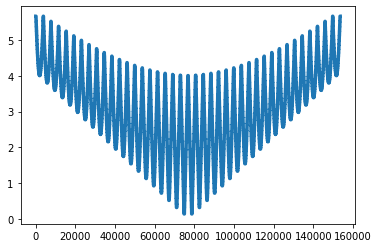

In [38]:
plt.plot(d_in.cpu())

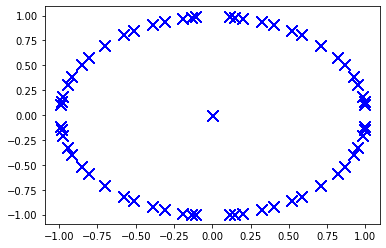

In [39]:
plt.plot(xy_in[:,0].cpu(), xy_in[:,1].cpu(), 'bx')

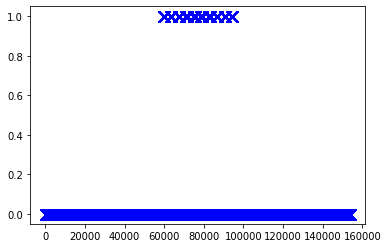

In [40]:
plt.plot((xy_in.cpu()**2).sum(dim=1), 'bx')

In [41]:
print(interact_pred)

tensor([[[[[[ 1.3929e-02,  2.7885e-02],
            [ 1.6016e-02,  3.0295e-02]],

           [[ 1.2510e-02,  3.0021e-02],
            [ 1.4479e-02,  3.0574e-02]]],


          [[[ 1.3791e-02,  2.7931e-02],
            [ 1.5906e-02,  3.0397e-02]],

           [[ 1.2313e-02,  3.0001e-02],
            [ 1.4287e-02,  3.0551e-02]]],


          [[[ 1.3387e-02,  2.8067e-02],
            [ 1.5540e-02,  3.0564e-02]],

           [[ 1.1734e-02,  2.9941e-02],
            [ 1.3731e-02,  3.0488e-02]]],


          ...,


          [[[ 1.2655e-02,  2.8150e-02],
            [ 1.4946e-02,  3.0788e-02]],

           [[ 1.0814e-02,  2.9845e-02],
            [ 1.2851e-02,  3.0396e-02]]],


          [[[ 1.3387e-02,  2.8067e-02],
            [ 1.5540e-02,  3.0564e-02]],

           [[ 1.1734e-02,  2.9941e-02],
            [ 1.3731e-02,  3.0488e-02]]],


          [[[ 1.3791e-02,  2.7931e-02],
            [ 1.5906e-02,  3.0397e-02]],

           [[ 1.2313e-02,  3.0001e-02],
            [ 1.4287e-02,  3.05

In [42]:
print(interact_truth)

tensor([[[[[[0., 0.],
            [0., 0.]],

           [[0., 0.],
            [0., 0.]]],


          [[[0., 0.],
            [0., 0.]],

           [[0., 0.],
            [0., 0.]]],


          [[[0., 0.],
            [0., 0.]],

           [[0., 0.],
            [0., 0.]]],


          ...,


          [[[0., 0.],
            [0., 0.]],

           [[0., 0.],
            [0., 0.]]],


          [[[0., 0.],
            [0., 0.]],

           [[0., 0.],
            [0., 0.]]],


          [[[0., 0.],
            [0., 0.]],

           [[0., 0.],
            [0., 0.]]]],



         [[[[0., 0.],
            [0., 0.]],

           [[0., 0.],
            [0., 0.]]],


          [[[0., 0.],
            [0., 0.]],

           [[0., 0.],
            [0., 0.]]],


          [[[0., 0.],
            [0., 0.]],

           [[0., 0.],
            [0., 0.]]],


          ...,


          [[[0., 0.],
            [0., 0.]],

           [[0., 0.],
            [0., 0.]]],


          [[[0., 0.],
  

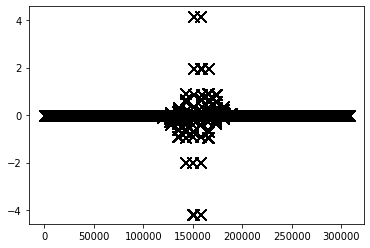

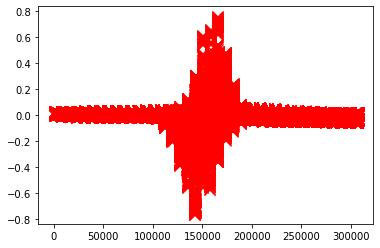

In [43]:
fig,ax = plt.subplots()
ax.plot(interact_truth.cpu().view(-1), 'kx')
fig,ax = plt.subplots()
ax.plot(interact_pred.cpu().view(-1), 'rx')

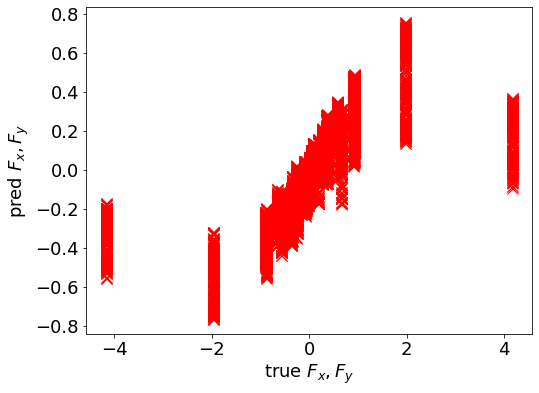

In [102]:
fig,ax = plt.subplots()
ax.plot(interact_truth.cpu().view(-1), interact_pred.cpu().view(-1), 'rx')
plt.xlabel(r'true $F_x, F_y$')
plt.ylabel(r'pred $F_x, F_y$')
fig.savefig(modeldirName + model_name + 'true_and_pred_force.png')

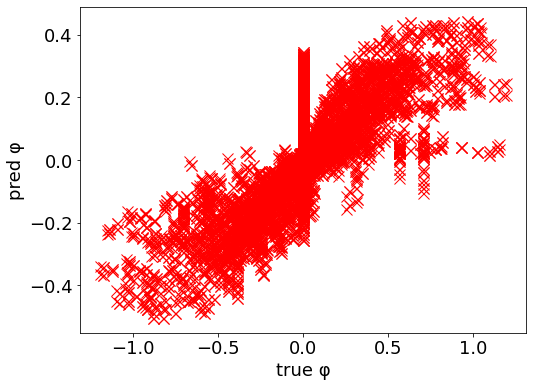

In [103]:
fig,ax = plt.subplots()
ax.plot(torque_truth.cpu().view(-1), torque_pred.cpu().view(-1), 'rx')
plt.xlabel('true φ')
plt.ylabel('pred φ')
fig.savefig(modeldirName + model_name + 'true_and_pred_torque.png')

In [89]:
plt.rcParams['font.size']=18
plt.rcParams['figure.figsize'] = [18,12]
plt.rcParams['savefig.bbox'] = 'tight'

plt.rcParams['image.cmap'] = 'magma'

plt.rcParams['lines.markersize'] = 11.0

plt.rcParams['lines.linewidth'] = 3.5

plt.rcParams['pgf.texsystem'] = 'pdflatex'

plt.rcParams['text.usetex'] = False

In [90]:
plt.rcParams

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'both',
          'axes.grid.which':

In [97]:
clim_interact_true = [-4,4]
clim_torque_true = [-1.2,1.2]

clim_interact_pred = [-0.8,0.8]
clim_torque_pred = [-0.5,0.5]

dy_true, dx_true = np.meshgrid(dx_grid, dy_grid)
dy_pred, dx_pred = np.meshgrid(dx_grid, dy_grid)

def pcolor_subplots(N_i, N_j, ij, xg, yg, cg, cl, title, xlabel="", ylabel=""):
    plt.subplot(N_i,N_j,ij)
    plt.pcolor(xg, yg, cg, clim=cl)
    plt.colorbar()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.axis('equal')

@interact(theta_p_j=(0, in_grid_shape[2]-1), type_i=(0, in_grid_shape[3]-1), type_j=(0, in_grid_shape[4]-1))
def f(theta_p_j, type_i, type_j):
    fig = plt.figure()
    fig.suptitle(r'$θ_j - θ_i = {:.2f}π, type_i = {}, type_j = {}$'.format(thetap_src[theta_p_j]/np.pi, type_i, type_j))
    pcolor_subplots(3,2,1, dx_true, dy_true, interact_truth[:,:,theta_p_j,type_i,type_j,0], clim_interact_true, r'true $F_x$', ylabel=r'$Δy_{ij}$')
    pcolor_subplots(3,2,3, dx_true, dy_true, interact_truth[:,:,theta_p_j,type_i,type_j,1], clim_interact_true, r'true $F_y$', ylabel=r'$Δy_{ij}$')
    pcolor_subplots(3,2,5, dx_true, dy_true, torque_truth[:,:,theta_p_j,type_i,type_j,0], clim_torque_true, 'true φ', xlabel=r'$Δx_{ij}$', ylabel=r'$Δy_{ij}$')
    pcolor_subplots(3,2,2, dx_pred, dy_pred, interact_pred[:,:,theta_p_j,type_i,type_j,0], clim_interact_pred, r'pred $F_x$')
    pcolor_subplots(3,2,4, dx_pred, dy_pred, interact_pred[:,:,theta_p_j,type_i,type_j,1], clim_interact_pred, r'pred $F_y$')
    pcolor_subplots(3,2,6, dx_pred, dy_pred, torque_pred[:,:,theta_p_j,type_i,type_j,0], clim_torque_pred, 'pred φ', xlabel=r'$Δx_{ij}$')
        


interactive(children=(IntSlider(value=11, description='theta_p_j', max=23), IntSlider(value=0, description='ty…

In [98]:
for theta_p_j in range(in_grid_shape[2]):
    print(theta_p_j)
    for type_i in range(in_grid_shape[3]):
        for type_j in range(in_grid_shape[4]):
            fig = plt.figure()
            fig.suptitle(r'$θ_j - θ_i = {:.2f}π, type_i = {}, type_j = {}$'.format(thetap_src[theta_p_j]/np.pi, type_i, type_j))
            pcolor_subplots(3,2,1, dx_true, dy_true, interact_truth[:,:,theta_p_j,type_i,type_j,0], clim_interact_true, r'true $F_x$', ylabel=r'$Δy_{ij}$')
            pcolor_subplots(3,2,3, dx_true, dy_true, interact_truth[:,:,theta_p_j,type_i,type_j,1], clim_interact_true, r'true $F_y$', ylabel=r'$Δy_{ij}$')
            pcolor_subplots(3,2,5, dx_true, dy_true, torque_truth[:,:,theta_p_j,type_i,type_j,0], clim_torque_true, 'true φ', xlabel=r'$Δx_{ij}$', ylabel=r'$Δy_{ij}$')
            pcolor_subplots(3,2,2, dx_pred, dy_pred, interact_pred[:,:,theta_p_j,type_i,type_j,0], clim_interact_pred, r'pred $F_x$')
            pcolor_subplots(3,2,4, dx_pred, dy_pred, interact_pred[:,:,theta_p_j,type_i,type_j,1], clim_interact_pred, r'pred $F_y$')
            pcolor_subplots(3,2,6, dx_pred, dy_pred, torque_pred[:,:,theta_p_j,type_i,type_j,0], clim_torque_pred, 'pred φ', xlabel=r'$Δx_{ij}$')
            fig.savefig(modeldirName + model_name + '{}_{}_{}_pred.png'.format(type_i, type_j, theta_p_j))
            plt.clf()
            plt.close()
            

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [48]:
in_grid = in_grid.cpu()

In [49]:
pdf_in = kde_train_semiLT(in_grid.view(-1, 6).to(device)).cpu().reshape(out_grid_shape[:-1])

In [50]:
print(pdf_in.min(), pdf_in.max())

tensor(0.) tensor(7.2275)


(array([1.5229e+05, 3.4400e+02, 1.4600e+02, 1.2200e+02, 8.4000e+01,
        8.8000e+01, 6.8000e+01, 3.0000e+01, 3.4000e+01, 3.4000e+01,
        3.8000e+01, 2.6000e+01, 3.8000e+01, 2.6000e+01, 2.8000e+01,
        2.8000e+01, 2.4000e+01, 2.6000e+01, 8.0000e+00, 2.0000e+00,
        2.0000e+00, 6.0000e+00, 4.0000e+00, 6.0000e+00, 2.0000e+00,
        4.0000e+00, 6.0000e+00, 6.0000e+00, 6.0000e+00, 4.0000e+00,
        2.0000e+00, 6.0000e+00, 2.0000e+00, 6.0000e+00, 2.0000e+00,
        4.0000e+00, 2.0000e+00, 4.0000e+00, 4.0000e+00, 4.0000e+00,
        4.0000e+00, 4.0000e+00, 2.0000e+00, 2.0000e+00, 2.0000e+00,
        8.0000e+00, 4.0000e+00, 2.0000e+00, 0.0000e+00, 6.0000e+00]),
 array([0.        , 0.1445501 , 0.2891002 , 0.4336503 , 0.5782004 ,
        0.72275054, 0.8673006 , 1.0118507 , 1.1564008 , 1.3009509 ,
        1.4455011 , 1.5900512 , 1.7346013 , 1.8791513 , 2.0237014 ,
        2.1682515 , 2.3128016 , 2.4573517 , 2.6019018 , 2.746452  ,
        2.8910022 , 3.0355523 , 3.1801023 , 3.

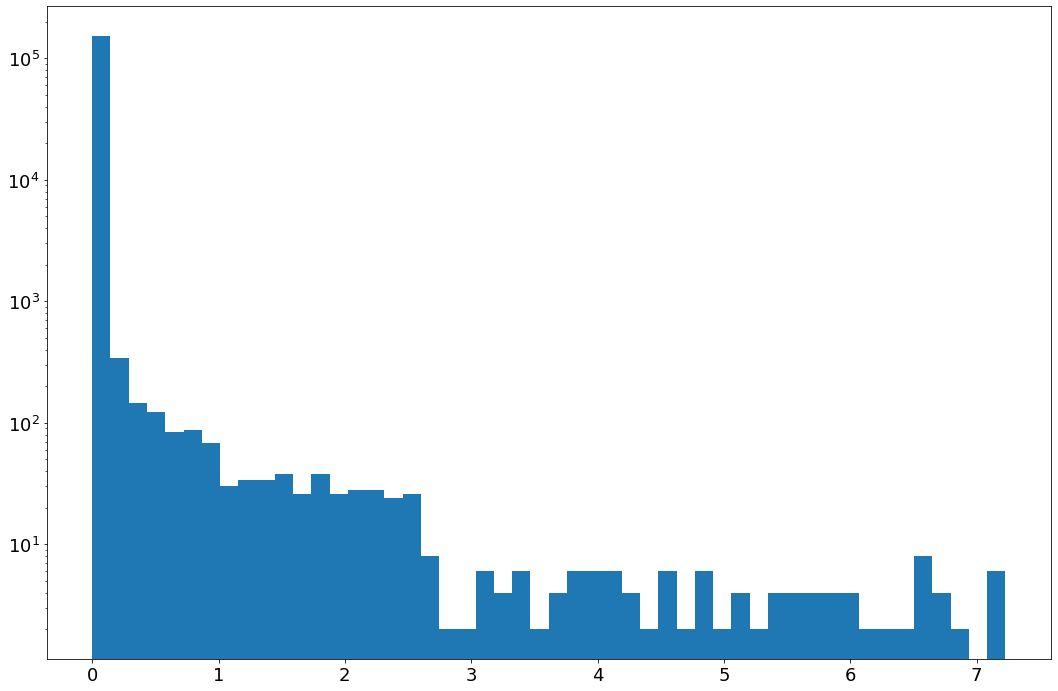

In [51]:
plt.hist(pdf_in.flatten(), 50, log=True)

(array([ 224.,  273.,  315.,  444.,  595.,  718.,  814.,  730.,  698.,
         734.,  771.,  756.,  638.,  624.,  647.,  712.,  721.,  872.,
         931.,  810.,  834.,  855., 1215., 1384.,  862.,  728.,  750.,
         814.,  819.,  874.,  882.,  903.,  877., 1051., 1421., 1879.,
        1639., 1028.,  943., 1155., 1517., 1756., 1964., 1927., 2358.,
        2024., 1802., 1376.,  708.,  414.]),
 array([-37.924915  , -37.14924   , -36.373558  , -35.59788   ,
        -34.822205  , -34.046524  , -33.270847  , -32.49517   ,
        -31.71949   , -30.943813  , -30.168135  , -29.392456  ,
        -28.61678   , -27.8411    , -27.065422  , -26.289743  ,
        -25.514067  , -24.738388  , -23.96271   , -23.187033  ,
        -22.411354  , -21.635675  , -20.859997  , -20.08432   ,
        -19.308641  , -18.532963  , -17.757286  , -16.981607  ,
        -16.205929  , -15.430251  , -14.654573  , -13.878895  ,
        -13.103217  , -12.3275385 , -11.551861  , -10.776183  ,
        -10.0005045 ,  -

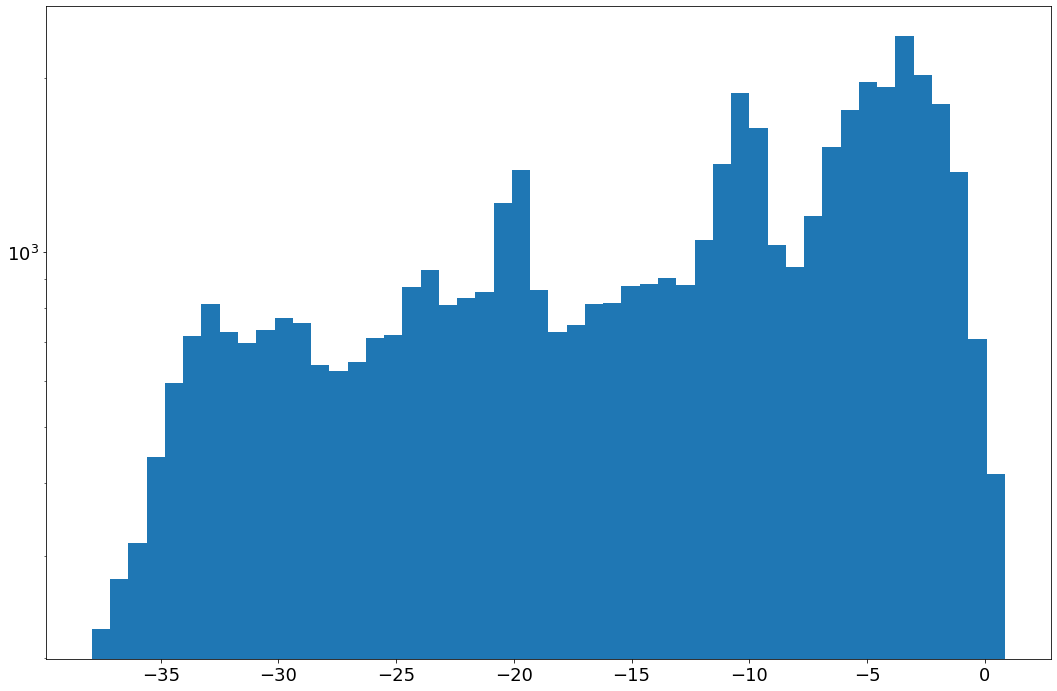

In [52]:
plt.hist(torch.log10(pdf_in[pdf_in>0]).flatten(), 50, log=True)

In [53]:
@interact(theta_p_j=(0, in_grid_shape[2]-1), type_i=(0, in_grid_shape[3]-1), type_j=(0, in_grid_shape[4]-1))
def f(theta_p_j, type_i, type_j):
    fig = plt.figure()
    pcolor_subplots(1,1,1, dx_true, dy_true, torch.log10(pdf_in[:,:,theta_p_j,type_i,type_j]), [-40,1], 'log10 of Estimated PDF of input data')


interactive(children=(IntSlider(value=11, description='theta_p_j', max=23), IntSlider(value=0, description='ty…

In [54]:
trainList_shape = trainList.shape
out_trainList_shape = list(trainList_shape)
out_trainList_shape[-1] = -1

In [55]:
tL = 0

In [56]:
with torch.no_grad():
    interact_pred_train = torch.cat([gnn_model.interactNN(tL.view(-1, 6).to(device)).cpu()\
                                     for tL in torch.split(trainList, 100000)], dim=0)
    torque_pred_train = torch.cat([gnn_model.thetaDotNN(tL.view(-1, 6).to(device)).cpu()\
                                   for tL in torch.split(trainList, 100000)], dim=0)

In [57]:
with torch.no_grad():
    xy_in_train, d_in_train = angle_abs(trainList[..., :2].view(-1, 2).to(device))
    interact_truth_train = torch.cat([interact_a(-xxt, ddt).cpu().reshape([-1,2])\
                                      for xxt, ddt in zip(torch.split(xy_in_train,100000), torch.split(d_in_train,100000))], dim=0)
    torque_truth_train = torch.cat([torque(-xxt, ddt, tL[:,2:4].to(device), p_dst.view(-1, 2), tL[:,4:5].to(device)).cpu()\
                                    for xxt, ddt, tL in zip(torch.split(xy_in_train,100000), torch.split(d_in_train,100000), torch.split(trainList, 100000))], dim=0)

In [58]:
flg_finite = torch.logical_and(torch.isfinite(interact_truth_train), torch.isfinite(interact_pred_train))

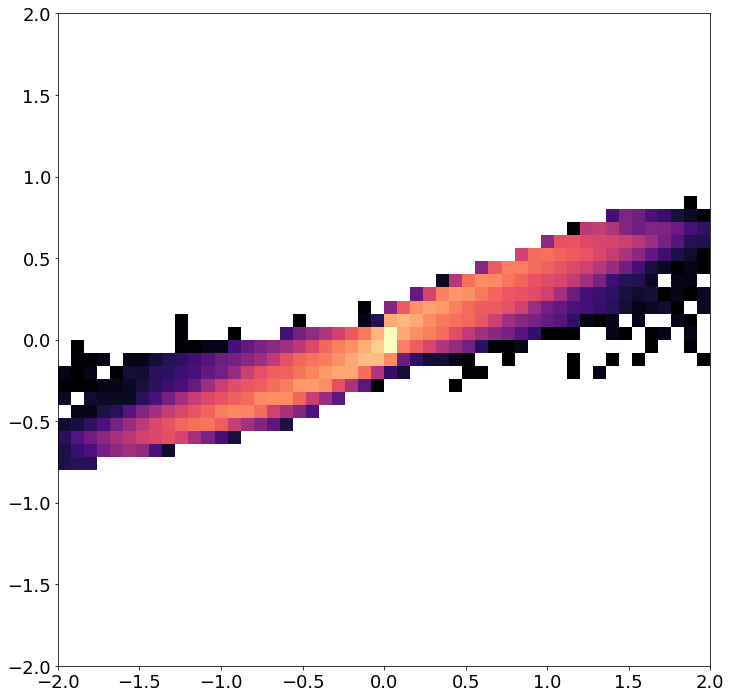

In [59]:
fig,ax = plt.subplots()
ax.hist2d(interact_truth_train[flg_finite].numpy(), interact_pred_train[flg_finite].numpy(), bins=50, range=[[-2,2], [-2,2]], norm=matplotlib.colors.LogNorm())
ax.set_aspect('equal')

In [60]:
torch.cuda.empty_cache()

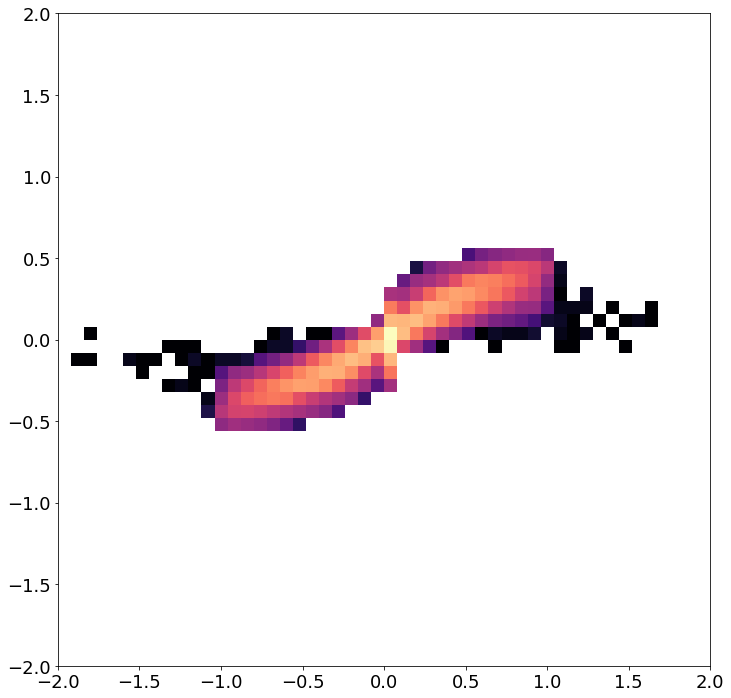

In [61]:
fig,ax = plt.subplots()
ax.hist2d(torque_truth_train[flg_finite[:,0], 0].numpy(), torque_pred_train[flg_finite[:,0], 0].numpy(), bins=50, range=[[-2,2], [-2,2]], norm=matplotlib.colors.LogNorm())
ax.set_aspect('equal')

In [62]:
interact_devRatio_train = interact_pred_train/interact_truth_train - 1
torque_devRatio_train = torque_pred_train/torque_truth_train - 1

In [63]:
pdf_train = kde_train_semiLT(trainList.view(-1, 6).to(device)).cpu()

In [64]:
print(pdf_train.min(), pdf_train.max())

tensor(0.0005) tensor(337.9774)


(array([1.400000e+01, 2.200000e+01, 4.000000e+01, 4.000000e+01,
        3.400000e+01, 4.900000e+01, 1.070000e+02, 1.410000e+02,
        3.100000e+02, 6.240000e+02, 1.281000e+03, 2.735000e+03,
        5.332000e+03, 1.070300e+04, 1.959400e+04, 2.974000e+04,
        5.063700e+04, 6.013700e+04, 7.763500e+04, 9.391100e+04,
        1.072830e+05, 1.326500e+05, 1.682870e+05, 2.242090e+05,
        3.086710e+05, 4.183370e+05, 5.565770e+05, 7.670610e+05,
        1.034219e+06, 1.228999e+06, 1.477288e+06, 1.756903e+06,
        1.664212e+06, 1.728712e+06, 1.411715e+06, 1.361968e+06,
        7.724120e+05, 6.961160e+05, 5.990100e+04, 0.000000e+00,
        4.000000e+00, 4.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 2.000000e+00, 3.600020e+05, 0.000000e+00,
        0.000000e+00, 8.400000e+05]),
 array([-3.344793  , -3.2273195 , -3.1098459 , -2.9923723 , -2.8748987 ,
        -2.757425  , -2.6399515 , -2.5224779 , -2.4050043 , -2.2875304 ,
        -2.1700568 , -2.0525832 , -1.9351097 , -

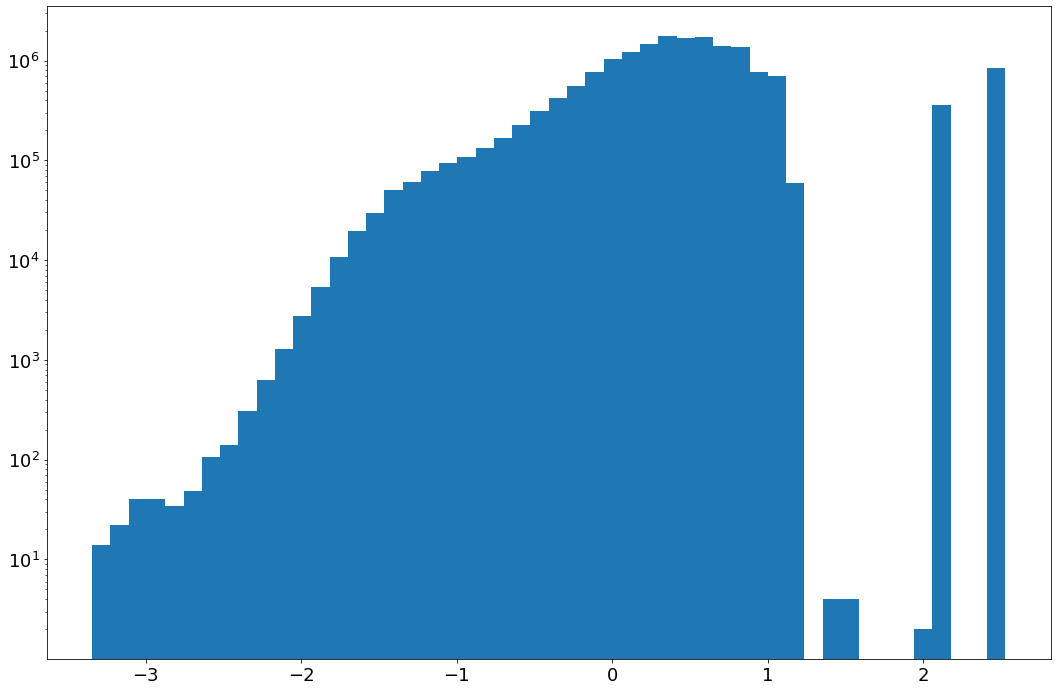

In [65]:
plt.hist(torch.log10(pdf_train[pdf_train>0]).flatten(), 50, log=True)

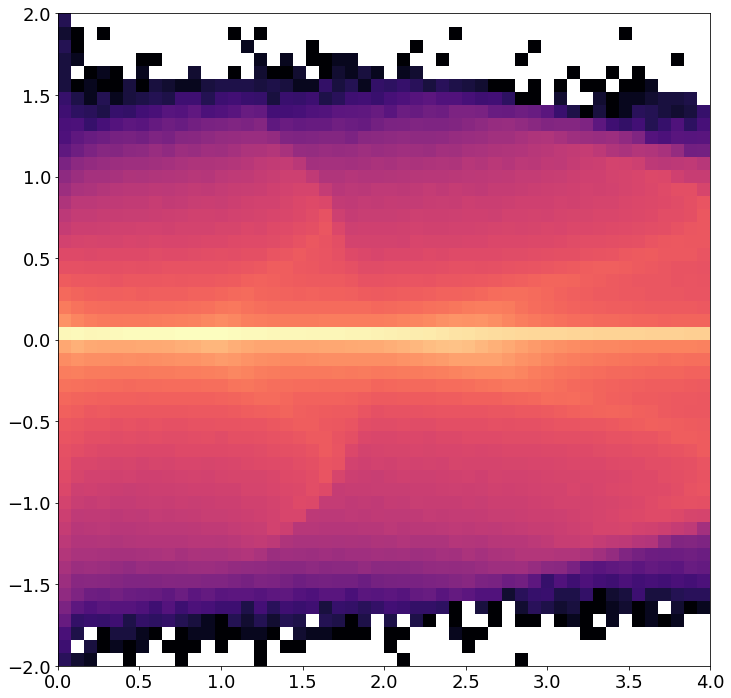

In [66]:
fig,ax = plt.subplots()
ax.hist2d(pdf_train[flg_finite[:,0], 0].numpy(), interact_truth_train[flg_finite[:,0], 0].numpy(), bins=50, range=[[0,4], [-2,2]], norm=matplotlib.colors.LogNorm())
ax.set_aspect('equal')

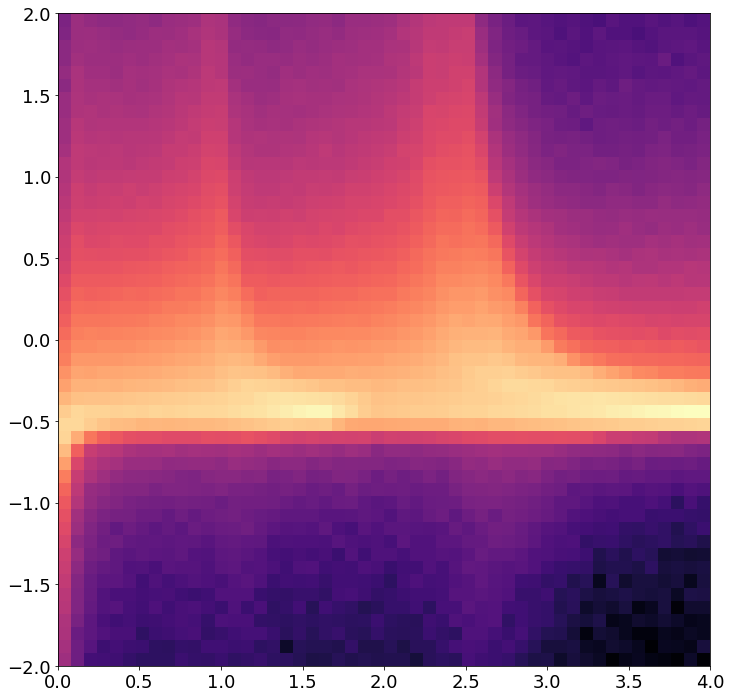

In [67]:
fig,ax = plt.subplots()
ax.hist2d(pdf_train[flg_finite[:,0], 0].numpy(), interact_devRatio_train[flg_finite[:,0], 0].numpy(), bins=50, range=[[0,4], [-2,2]], norm=matplotlib.colors.LogNorm())
ax.set_aspect('equal')

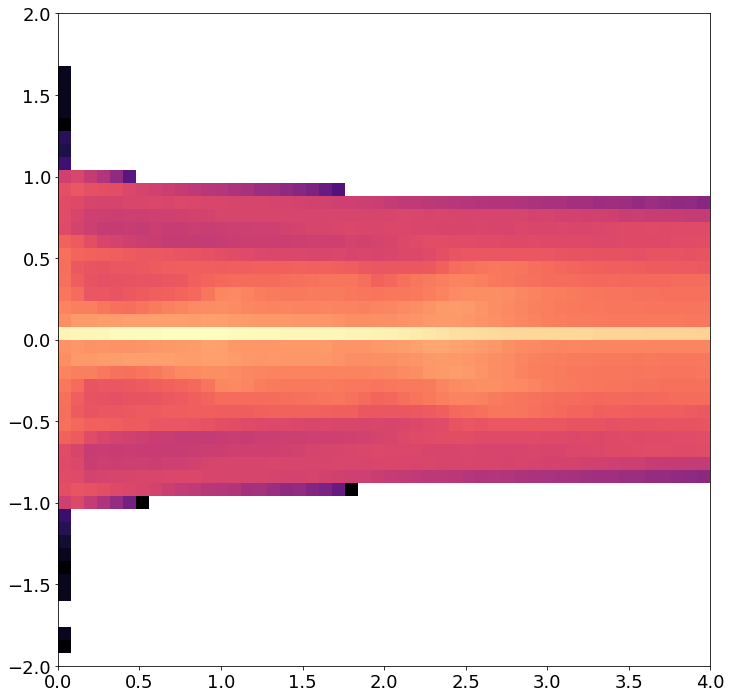

In [68]:
fig,ax = plt.subplots()
ax.hist2d(pdf_train[flg_finite[:,0], 0].numpy(), torque_truth_train[flg_finite[:,0], 0].numpy(), bins=50, range=[[0,4], [-2,2]], norm=matplotlib.colors.LogNorm())
ax.set_aspect('equal')

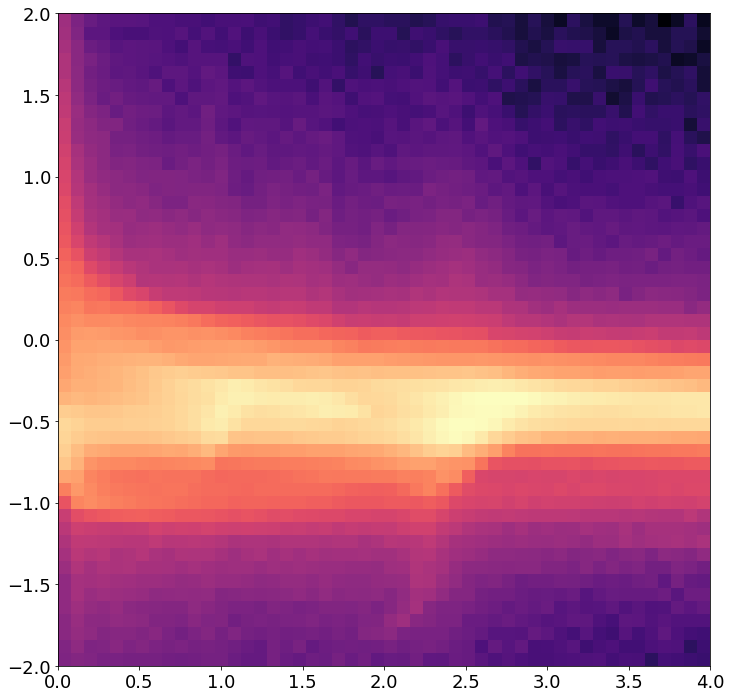

In [69]:
fig,ax = plt.subplots()
ax.hist2d(pdf_train[flg_finite[:,0], 0].numpy(), torque_devRatio_train[flg_finite[:,0], 0].numpy(), bins=50, range=[[0,4], [-2,2]], norm=matplotlib.colors.LogNorm())
ax.set_aspect('equal')